In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta
import re

### import the data

In [2]:
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
data['event_time'] = pd.to_datetime(data['event_time'].str.strip(), format='%Y-%m-%d %H:%M:%S %Z')
data = data.sort_values('event_time', ascending=True)
data = data[data['user_session'].notnull()]
data 

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02+00:00,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09+00:00,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10+00:00,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11+00:00,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24+00:00,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
...,...,...,...,...,...,...,...,...,...
4635832,2019-11-30 23:59:46+00:00,view,5830317,1487580009496313889,NaN,NaN,4.76,457678989,ee50b160-a4db-4722-8751-6812c5b38295
4635833,2019-11-30 23:59:47+00:00,view,5733064,1487580004832248652,NaN,beautix,9.37,422196217,ab5e6dd5-8700-4ecc-a300-9f1eca5d1a95
4635834,2019-11-30 23:59:47+00:00,view,5867785,1487580007835370453,NaN,kims,31.1,572579084,d42865b7-7e04-4038-9be0-a59165625f06
4635835,2019-11-30 23:59:57+00:00,view,5779406,2151191071051219817,NaN,NaN,2.86,540006764,d4b5aa49-d731-40f1-92f1-277416d6e063


## Q1

#### Add a new column to the dataframe called "duration_to_next_event" that will hold the time in seconds from an event until the next event that occurs during the same visit. For the last event in the visit, the value in this field should be 0.

In [3]:
data['duration_to_next_event'] = data.groupby('user_session')['event_time'].diff(-1)
data['duration_to_next_event'] = np.abs(data['duration_to_next_event']).dt.total_seconds()
data['duration_to_next_event'] = data['duration_to_next_event'].fillna(0)
data.iloc[np.where(data['user_id'] == 10280338)] # an example for a user from the data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event
0,2019-11-01 00:00:02+00:00,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,23.0
1,2019-11-01 00:00:09+00:00,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,15.0
2,2019-11-01 00:00:10+00:00,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f,45.0
3,2019-11-01 00:00:11+00:00,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7,103.0
4,2019-11-01 00:00:24+00:00,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,0.0


## Q2

#### Add a column called "funnel_number". A funnel is a sequence of visits (sessions) made by the same user on the website, with no more than 5 days between them. For example, if user X visits the site on 01/01/2023, 02/01/2023, 05/01/2023, 11/01/2023, and 12/01/2023, it is considered that there were 2 funnels. The first funnel of user X (which includes the visits on 01/01/2023, 02/01/2023, and 05/01/2023) will be marked as funnel_number=1, and the second funnel (which includes the visits on 11/01/2023 and 12/01/2023) will be marked as funnel_number=2.

In [4]:
data = data.sort_values(['user_id', 'event_time'])
data['time_diff'] = data.groupby('user_id')['event_time'].diff()
data['is_funnel_start'] = data['time_diff'].gt(pd.Timedelta(days=5))
data['funnel_number'] = data.groupby('user_id')['is_funnel_start'].cumsum() + 1
data = data.drop(['time_diff', 'is_funnel_start'], axis=1)
data.iloc[np.where(data['user_id'] == 10280338)] # an example for a user from the data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number
2683576,2019-11-20 18:08:14+00:00,cart,5809910,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,8.0,1
2683594,2019-11-20 18:08:22+00:00,cart,5809912,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,5.0,1
2683611,2019-11-20 18:08:27+00:00,view,5814046,1487580005092295511,NaN,grattol,6.27,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,17.0,1
2683649,2019-11-20 18:08:44+00:00,remove_from_cart,5868787,1924049110428549877,NaN,oniq,10.32,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,1.0,1
2683653,2019-11-20 18:08:45+00:00,remove_from_cart,5885779,1924049110428549877,NaN,oniq,10.32,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...
3904911,2019-11-27 04:31:41+00:00,view,5900480,1761186209054327497,NaN,NaN,9.19,10280338,aaefeac4-ea7b-d824-7685-67737473868b,49.0,2
3904945,2019-11-27 04:32:30+00:00,view,5902112,1487580007675986893,NaN,NaN,2.38,10280338,aaefeac4-ea7b-d824-7685-67737473868b,257.0,2
3905167,2019-11-27 04:36:47+00:00,view,5876344,1487580013950664926,NaN,NaN,55.56,10280338,aaefeac4-ea7b-d824-7685-67737473868b,804.0,2
3905777,2019-11-27 04:50:11+00:00,remove_from_cart,5900653,1819693959081886239,NaN,kinetics,6.51,10280338,aaefeac4-ea7b-d824-7685-67737473868b,7.0,2


## Q3

#### Add a column called "index_in_funnel" which will contain the number of the visit (session) in the same funnel. For example, following the previous example, for user X, the three visits in the first funnel will receive numbers 1, 2, 3, and the two visits in the second funnel will receive numbers 1, 2. Of course, if there are multiple events in the same visit, they will all receive the same index_in_funnel value.

In the code I did Group by user_id and funnel_number, and calculate the index (number each item in each group from 1 to the length of that group). 
<br>
The transform method applies the 'first' function to the index_in_funnel column of each group, returning the first occurrence of the value of index_in_funnel in each group.
<br>
Now we have the same index for each session but there are jumps between session indexes that are greater than one
calculating the difference between index in funnel for each user.
<br>
We calculated the jumps in the index. 
<br>
Adding 1 to cumulative sum to get the new index in funnel and droping unnecessary columns.

In [5]:
data = data.sort_values(['user_id', 'funnel_number','event_time', 'user_session'])


data['Index_in_funnel'] = data.groupby(['user_id', 'funnel_number']).cumcount() + 1
data['Index_in_funnel'] = data.groupby(['user_id', 'funnel_number', 'user_session'])['Index_in_funnel'].transform('first')

data['index_diff'] = data.groupby('user_id')['Index_in_funnel'].diff()
data['is_index_start'] = data['index_diff'].gt(data['index_diff'] > 1)
data['Index_in_funnel'] = data.groupby('user_id')['is_index_start'].cumsum() + 1

data = data.drop(['index_diff', 'is_index_start'], axis=1)

data = data.sort_values(['user_id', 'funnel_number','event_time', 'user_session', 'Index_in_funnel'])
data.iloc[np.where(data['user_id'] == 10280338)] # an example for a user from the data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,Index_in_funnel
2683576,2019-11-20 18:08:14+00:00,cart,5809910,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,8.0,1,1
2683594,2019-11-20 18:08:22+00:00,cart,5809912,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,5.0,1,1
2683611,2019-11-20 18:08:27+00:00,view,5814046,1487580005092295511,NaN,grattol,6.27,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,17.0,1,1
2683649,2019-11-20 18:08:44+00:00,remove_from_cart,5868787,1924049110428549877,NaN,oniq,10.32,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,1.0,1,1
2683653,2019-11-20 18:08:45+00:00,remove_from_cart,5885779,1924049110428549877,NaN,oniq,10.32,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,7.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3904911,2019-11-27 04:31:41+00:00,view,5900480,1761186209054327497,NaN,NaN,9.19,10280338,aaefeac4-ea7b-d824-7685-67737473868b,49.0,2,3
3904945,2019-11-27 04:32:30+00:00,view,5902112,1487580007675986893,NaN,NaN,2.38,10280338,aaefeac4-ea7b-d824-7685-67737473868b,257.0,2,3
3905167,2019-11-27 04:36:47+00:00,view,5876344,1487580013950664926,NaN,NaN,55.56,10280338,aaefeac4-ea7b-d824-7685-67737473868b,804.0,2,3
3905777,2019-11-27 04:50:11+00:00,remove_from_cart,5900653,1819693959081886239,NaN,kinetics,6.51,10280338,aaefeac4-ea7b-d824-7685-67737473868b,7.0,2,3


This is an evident that there is a discontinuity in the timestamps of the index in funnel. This can be attributed to the fact that a single user may access the website from multiple devices simultaneously or at different times, resulting in a blend of user sessions and hence the inconsistency.

## Q4

#### In the "price" column, prices (float) should appear, but in some rows, there are strings such as "2.44 sale, net 5.44". You should remove any text beyond the price itself from the column and convert the value in the field to a float. Regular expressions should be used for this purpose.





In [6]:
data = data.astype({'price':str})
# data[['price']].sort_values(by = 'price',ascending=False).head(10)

# define a function to clean the price column
def clean_price(item):
    match = re.search('[0-9]+?\.[0-9]+', str(item))
    if match:
        return float(match.group())
    else:
        return None

# apply the clean_price function to the price column
data['price'] = data['price'].apply(clean_price)
data = data[data['price'].notnull()]
data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,Index_in_funnel
437209,2019-11-04 15:28:57+00:00,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,0.0,1,1
2483241,2019-11-19 09:56:09+00:00,view,5711145,1487580005008409427,NaN,f.o.x,6.03,1458813,b16644a2-44db-4650-8156-f6f03782d432,0.0,1,1
2494623,2019-11-19 11:14:48+00:00,view,5814066,1487580005855658874,NaN,grattol,2.30,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,0.0,1,2
2640971,2019-11-20 11:58:06+00:00,view,5800358,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,21.0,1,3
2641003,2019-11-20 11:58:27+00:00,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,72.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4635733,2019-11-30 23:56:14+00:00,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,3.0,1,1
4635736,2019-11-30 23:56:17+00:00,view,5900651,1487580013950664926,NaN,NaN,19.52,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,4.0,1,1
4635737,2019-11-30 23:56:21+00:00,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0.0,1,1
4635752,2019-11-30 23:56:46+00:00,view,5790563,1487580008263189483,NaN,NaN,7.14,579968937,878af093-7570-48ae-966c-d50ce61e390c,0.0,1,1


## Q5

#### What are the existing event types? Create a chart that describes the number of events for each type.

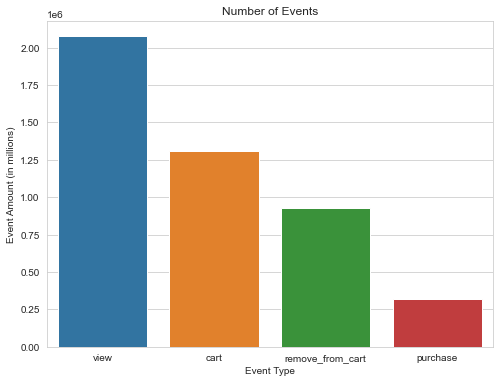

In [7]:
num_of_each_events = data['event_type'].value_counts().astype(float)
num_of_each_events = pd.DataFrame(num_of_each_events)
num_of_each_events = num_of_each_events.reset_index()
num_of_each_events.rename(columns={'event_type': 'event_amount', 'index': 'event_type'}, inplace=True)



sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
sns.barplot(x='event_type', y='event_amount', data=num_of_each_events)
plt.title('Number of Events')
plt.xlabel('Event Type')
plt.ylabel('Event Amount (in millions)')
plt.show()

## Q6

#### Create a new dataframe named "session_data" with the following columns representing each user session on the website:
a. User_id
<br>
b. User_session - session identifier
<br>
c. funnel_number
<br>
d. index_in_funnel
<br>
e. total number of events performed by the user during that session
<br>
f. duration of the session on the website
<br>
g. list_of_viewed - list of products the user viewed during the session
<br>
h. list_of_added_to_cart - list of products the user added to their cart during the session
<br>
i. list_of_purchased - list of products the user purchased during the session


In [10]:
# We have created the following columns in the previous sections, so we'll just merge them into a new data frame called 'session data'
session_data = data[['user_id', 'user_session', 'funnel_number', 'Index_in_funnel']]

# We will create a new data frame for the type and amount of events performed by a user on the same visit,
# using Groupby, we will count the number of events performed and connect it to the new data frame session data
data = data.sort_values(['user_session'])

number_of_events = data[['user_session', 'event_type']].groupby('user_session').count().reset_index()
number_of_events = number_of_events.rename(columns = {'event_type': 'number_of_events'})

session_data = pd.merge(session_data, number_of_events, on='user_session', how='inner')

# Using the column we created in the first section,
# by groupby we will sum this column, thus we will get the duration of the visit\session in seconds
data = data.sort_values(['user_session'])

duration_of_session_in_seconds = data[['user_session', 'duration_to_next_event']].groupby('user_session').sum().reset_index()
duration_of_session_in_seconds = duration_of_session_in_seconds.rename(columns = {'duration_to_next_event': 'duration_of_session_in_seconds'})

session_data = pd.merge(session_data, duration_of_session_in_seconds, on='user_session', how='inner')

# Arrange the information only for the type of event we need,
# we'll use aggregation to create lists of values in a separate data frame,
# and then we will connect it to the new data frame session data.
only_view = data[data['event_type'] == 'view']
only_added_to_cart = data[data['event_type'] == 'cart']
only_purchase = data[data['event_type'] == 'purchase']

list_of_viewed = only_view.groupby(['user_session']).agg({'product_id': lambda x: list(x)}).reset_index()
list_of_viewed.rename(columns = {'product_id': 'list_of_viewed'}, inplace=True)

list_of_added_to_cart = only_added_to_cart.groupby(['user_session']).agg({'product_id': lambda x: list(x)}).reset_index()
list_of_added_to_cart.rename(columns = {'product_id': 'list_of_added_to_cart'}, inplace=True)

list_of_purchased = only_purchase.groupby(['user_session']).agg({'product_id': lambda x: list(x)}).reset_index()
list_of_purchased.rename(columns = {'product_id': 'list_of_purchased'}, inplace=True)

session_data = pd.merge(session_data, list_of_viewed, on='user_session', how='inner')
session_data = pd.merge(session_data, list_of_added_to_cart, on='user_session', how='inner')
session_data = pd.merge(session_data, list_of_purchased, on='user_session', how='inner')

session_data = session_data.drop_duplicates(subset='user_session') # geting rid of identical rows by the key column user session
session_data = session_data.sort_values(['user_id', 'user_session', 'funnel_number','Index_in_funnel']) 

data = data.sort_values(['user_id', 'user_session', 'funnel_number','Index_in_funnel'])
data.iloc[np.where(data['user_id'] == 560528468)] # Examination
# data.iloc[np.where(data['user_id'] == 10280338)] # an example for a user from the data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,Index_in_funnel
1223991,2019-11-09 16:53:56+00:00,view,5884033,2114584564549550293,NaN,NaN,4.06,560528468,0e44319f-d0f3-47f8-b337-b343c5f6c82a,0.0,1,1
1225055,2019-11-09 17:02:09+00:00,view,5884033,2114584564549550293,NaN,NaN,4.06,560528468,48d3d5fd-1197-4386-af85-4b1aa6967275,0.0,1,3
2255525,2019-11-17 18:32:00+00:00,view,5714240,1487580006434472855,NaN,jas,123.81,560528468,6ea63479-145e-4447-8ea6-4ed31c86b3fe,0.0,1,8
1910767,2019-11-14 19:59:27+00:00,view,5714240,1487580006434472855,NaN,jas,123.81,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,0.0,1,7
1910720,2019-11-14 19:59:12+00:00,view,16690,1487580013950664926,NaN,enas,9.98,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,15.0,1,7
1910391,2019-11-14 19:55:54+00:00,view,5884356,1487580010561667147,NaN,oniq,10.32,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,92.0,1,7
1910532,2019-11-14 19:57:26+00:00,view,5745356,1487580010360340546,NaN,NaN,8.25,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,106.0,1,7
1224476,2019-11-09 16:58:06+00:00,view,5884040,2114584564549550293,NaN,NaN,4.06,560528468,abd21e8c-42cb-4006-85d8-1d525301ddb2,0.0,1,2
1225179,2019-11-09 17:02:53+00:00,view,5847328,1982860244379763042,NaN,NaN,8.25,560528468,bbb3c66d-7492-4508-b3d8-7e2ca24d78e1,0.0,1,5
1250772,2019-11-09 20:32:42+00:00,view,5879286,1487580008607122425,NaN,masura,9.51,560528468,d85ecf56-9e61-4f38-a100-016eed9066d9,0.0,1,6
